# Projeto Final - Otimização e Computação Evolucionária


## Alunos: Eduardo Ximenes, Matheus Gomes Maranhão, Vitor Peter

O presente projeto foi realizado como atividade de conclusão da disciplina de Otimização e Computação Evolucionária. A atividade consiste no uso dos conhecimentos adquiridos ao longo das aulas, através da aplicação do Algoritmos Genético e Particle Swarm Optimization com o objetivo de realizar a clusterização de um dataset e regressão com seleção de features no outro dataset. 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score, jaccard_score, r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


import time

# Loading bar acompanhar o progresso no "treinamento"
import tqdm
from tqdm.notebook import tqdm_notebook

if 'IPython' in globals() and IPython.get_ipython():
    tqdm_func = tqdm_notebook
else:
    tqdm_func = tqdm.tqdm

## Dataset 1: Churn Prediction  
Com este dataset, será feita uma clusterização com o modelo KMeans usando um método fit ajustado por computação evolucionária. A ideia será comparar essa solução com o modelo padrão. A métrica utilizada foi o índice de silhueta.

In [2]:
df_churn = pd.read_csv('./data/churn_prediction.csv')

In [3]:
print(df_churn.head(1))
df_churn.info()

   customer_id  credit_score country  gender  age  tenure  balance  \
0     15634602           619  France  Female   42       2      0.0   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  

In [4]:
X= df_churn.drop('churn',axis=1)
y = df_churn['churn']

gender_mapping = {'Male': 1, 'Female': 0}
X['gender'] = X['gender'].map(gender_mapping).astype('int8')

dummies = pd.get_dummies(X['country'], drop_first=True)
X.drop(['country','customer_id'],axis=1,inplace=True)
X = pd.concat([X, dummies], axis=1)

X.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,False,True


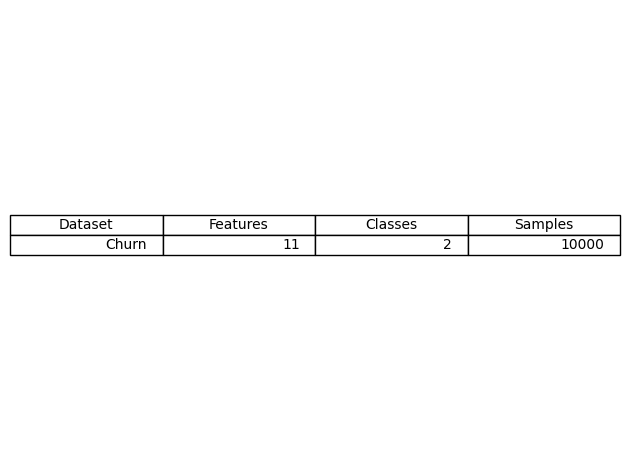

In [5]:
# Plotando tabela com numero de features, classes e samples do dataset

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=[['Churn',X.shape[1],len(y.unique()),X.shape[0]],
                  ],
         colLabels=['Dataset','Features','Classes','Samples'],
         loc='center')
fig.tight_layout()

plt.show()


### Definição de classe para obtenção do baseline para comparação - KMeans

In [6]:
class KMeansEvol(KMeans):
    def __init__(self, n_clusters=2, init='k-means++', precomputed_centroids=None, **kwargs):
        super().__init__(n_clusters=n_clusters, init=init,n_init="auto", **kwargs)
        self.precomputed_centroids = precomputed_centroids # inicializar a variável que recebe os centróides otimizados pelo GA

    def fit(self, X, y=None, sample_weight=None):
        self.cluster_centers_ = self.precomputed_centroids
        self._n_threads = 1 # input para self.predict()
        self.labels_ = self.predict(X)  # Prever partições de cada amostra
        return self

### Definição de Funções para aplicação do GA e PSO

In [7]:
# Funções para o algoritmo genético

def init_pop(P,n_f,n_c, X):
    """
    Inicialize P indivíduos da população. Cada indivíduo contém n_c
    centróides.

    Parâmetros:
    P: Número de indivíduos na população
    n_c: Número de centróides em cada grupo
    n_f: Número de características no conjunto de dados
    X: Conjunto de dados

    Retorna:
    população inicial com P indivíduos
    """
    pop = []
    # loop em todos os indivíduos
    for _ in range(P):
        # Inicializar indivíduo
        centroids = []
        # loop em cada centródide do indivíduo
        for __ in range(n_c):
          # loop em cada feature
          centroid = []
          for feature_index in range(n_f):
              # Gerar a coordenada do centróide associada à feature
              coordinate_f = np.random.uniform(np.min(X[:, feature_index]), np.max(X[:, feature_index]))
              centroid.append(coordinate_f)
          # adicionar centróide ao indivíduo
          centroids.extend(centroid)
        # adicionar indivíduo na pop
        pop.append(np.array(centroids))

    return pop

def fitness_function(ind, n_clusters,n_f, X):

    # Assumindo que o conjunto de centróides de um indivíduo é representado por:
    #np.array([[x1_(1) x1_(2) x1_(3) ... x1_(n_f)] ... [x(n_c)_(1) x(n_c)_(2) x(n_c)_(3) ... x(n_c)_(n_f)] ])
    # onde: n_f-> número de características, n_c-> número de clusters
    # transformar em um array com dimensões (n_clusters x n_f)
    ind_ready = np.reshape(ind, (n_clusters, n_f))

    # Criar instância do KMeansEvol
    kmeans_ga = KMeansEvol(n_clusters=n_clusters, precomputed_centroids=ind_ready)
    kmeans_ga.fit(X)

    # Calcular a métrica silhouette como a fitness do indivíduo
    labels = kmeans_ga.labels_
    if all(x == labels[0] for x in labels): # se somente um cluster existir
      silhouette_avg = -1
    else:
      silhouette_avg = silhouette_score(X, labels)


    # Estamos maximizando a silhouette, então retorne o valor multiplicado por (-1)
    return -silhouette_avg, kmeans_ga

def select_individuals(population):
    """
    Selecione dois indivíduos da população aleatoriamente para P seleções.

    Parâmetros:
    population: Lista ou array representando a população.

    Retorna:
    Lista de tuplas, cada uma contendo os índices de dois indivíduos selecionados aleatoriamente.
    """
    population_size = len(population)
    selections = []

    for _ in range(population_size-1):
        # Selecione dois indivíduos com reposição
        selected_indices = np.random.choice(population_size, size=2, replace=True)
        selections.append(tuple(selected_indices))

    return selections

def uniform_crossover(parent1, parent2, crossover_rate=0.5):
    """
    Realize o cruzamento uniforme entre dois pais.

    Parâmetros:
    parent1: genes do primeiro pai.
    parent2: genes do segundo pai.
    crossover_rate: Probabilidade de selecionar um gene do parent1

    Retorna:
    genes da criança após o cruzamento uniforme.
    """

    # Gerar uma lista aleatória booleana, onde o elemento da lista é igual a True, se p < crossover_rate
    mask = np.random.rand(len(parent1)) < crossover_rate

    # Realizar crossover
    child = np.where(mask, parent1, parent2)

    return child.tolist()


def mutation(child, p_m=0.2, mutation_scale_factor=0.1):
    """

    Aplicar mutação aos genes de uma criança.

    Parâmetros:
    child: genes da criança.
    p_m: Probabilidade de aplicar mutação a cada gene.
    mutation_std_dev: Desvio padrão da distribuição normal para a mutação.

    Retorna:
    genes da criança após a mutação.
    """
    mutated_child = np.copy(child)

    data_std_dev = np.std(child)
    mutation_std_dev = mutation_scale_factor * data_std_dev

    # Faça o loop em cada gene e mute-o com probabilidade p_m
    for i in range(len(child)):
        if np.random.rand() < p_m:
            # Aplique a mutação perturbando o gene com uma distribuição normal
            mutated_child[i] += np.random.normal(loc=0, scale=mutation_std_dev)

    return mutated_child.tolist()

def genetic_algorithm(pop_size, p_crossover, p_mutation, data, n_clusters,n_f, max_generations):

    """
    Loop do algoritmo genético.

    Parâmetros:
    pop_size: Tamanho da população.
    p_crossover: Probabilidade de crossover.
    p_mutation: Probabilidade de mutação.
    X: Conjunto de dados.
    n_clusters: Número de clusters.
    n_features: Número de características.
    max_generations: Número máximo de gerações.

    Retorna:
    Melhor conjunto de centróides obtido pelo algoritmo genético.
    """
    # inicializar os dados
    X = data
    # inicializar pop
    pop = init_pop(pop_size,n_f,n_clusters,X)
    # lista para armazenar evolução da fitness
    fitness_over_time = []
    print('Treinando algorítimo genético...')
    for generation in tqdm_func(range(max_generations), desc="GA Progress"):
        # avaliar fitness dos indivíduos da pop
        #fitness_values = [fitness_function(ind, n_clusters, X) for ind in pop]
        # selecionar melhor indivíduo com base na fitness
        best_ind = min(pop, key=lambda ind: fitness_function(ind, n_clusters,n_f, X)[0])
        # armazenar melhor fitness desta geração
        best_fitness_val, best_kmeans_ga = fitness_function(best_ind, n_clusters,n_f, X)
        fitness_over_time.append(-best_fitness_val)

        # Selecionar pais para reprodução
        selections = select_individuals(pop)

        # Criar nova população com crossover e mutação
        offspring = []
        for parent1, parent2 in selections:
            child = uniform_crossover(pop[parent1], pop[parent2], p_crossover)
            child = mutation(child, p_mutation)
            offspring.append(child)
        offspring.append(best_ind)

        # Atualizar população
        pop = offspring

    return best_ind, fitness_over_time


# Funções para o algoritmo PSO

def init_swarm(P,n_f,n_c, X):
    """
    Inicialize P indivíduos da população. Cada indivíduo contém n_c
    centróides.

    Parâmetros:
    P: Número de partículas no enxame
    n_c: Número de centróides em cada grupo
    n_f: Número de características no conjunto de dados
    X: Conjunto de dados

    Retorna:
    pos = posição inicial das P partículas do enxame
    vel = velocidade inicial das P partículas do enxame
    pos_best = vetor de melhores posições conhecidas pela partícula
    """
    pos = []
    vel = []
    pos_best = []
    # loop em todas as partículas
    for _ in range(P):
        # Inicializar posição da partícula
        centroids = []
        # loop em cada centródide da partícula
        for __ in range(n_c):
          # loop em cada feature
          centroid = []
          for feature_index in range(n_f):
              # Gerar a coordenada do centróide associada à feature
              coordinate_f = np.random.uniform(np.min(X[:, feature_index]), np.max(X[:, feature_index]))
              centroid.append(coordinate_f)
          # adicionar centróide à partícula
          centroids.extend(centroid)
        # adicionar posicao inicial da partícula (grupo de centróides)
        pos.append(np.array(centroids))
        pos_best.append(np.array(centroids))
        # adicionar velocidade inicial da partícula
        vel.append(np.random.uniform(-1,1, size = (n_f*n_c)))


    return pos, vel, pos_best

# atualizar velocidade da partícula
def update_velocity(pos, vel, pos_best, global_best, w, c1, c2):
  '''
    Atualiza a velocidade da partícula usando a fórmula da Otimização por Enxame de Partículas (PSO).

    Parâmetros:
    pos: posição atual da partícula
    vel: velocidade atual da partícula
    pos_best: Melhor posição global entre todas as partículas.
    c1: Parâmetro cognitivo.
    c2: Parâmetro social.
    w: Peso de inércia.

    Retorna:
    - Velocidade atualizada para a partícula.
  '''
  # inicializar vel atualizada
  vel_updated = []
  # loop em cada posição i da partícula
  for i in range(len(pos)):
      # Gera números aleatórios no intervalo [0, 1]
      r1 = np.random.uniform(0,1)
      r2 = np.random.uniform(0,1)

      # Calcula os componentes cognitivo e social da atualização de velocidade
      vel_cognitive = c1 * r1 * (pos_best[i] - pos[i])
      vel_social = c2 * r2 * (global_best[i] - pos[i])

      # Atualiza a velocidade i usando a fórmula do PSO
      vel_updated.append(w * vel[i] + vel_cognitive + vel_social)

  # Retorna a velocidade atualizada para a partícula
  return np.array(vel_updated)

# definir função de atualização da posição
def update_position(pos, vel, bounds):
  '''
    Atualiza a posição da partícula a partir da nova velocidade.

    Parâmetros:
    pos: posição atual da partícula
    vel: velocidade atualizada da partícula
    bounds: limites do ambiente

    Retorna:
    - Velocidade atualizada para a partícula.
  '''
  pos_updated = []
  for i in range(len(pos)):
      pos_updated.append(np.clip(pos[i]+vel[i], a_min=bounds[0], a_max=bounds[1]))
  return pos_updated

def pso(swarm_size, c1, c2, w, data, n_clusters,n_f, max_iters):
  """
  Loop do PSO.

  Parâmetros:
  swarm_size: num de partículas.
  c1: Parâmetro cognitivo.
  c2: Parâmetro social.
  w: Peso de inércia.
  X: Conjunto de dados.
  n_clusters: Número de clusters.
  n_features: Número de características.
  max_iters: Número máximo de períodos.

  Retorna:
  Melhor conjunto de centróides obtido pelo algoritmo genético.
  """
  # inicializar os dados
  X = data
  bounds = [np.min(X), np.max(X)] # valor mínimo e máximo global de X
  # inicializar o enxame
  pos_swarm, vel_swarm, pos_best_swarm = init_swarm(swarm_size,n_f,n_clusters,X)
  # lista para armazenar evolução da fitness
  fitness_over_time = []

  # comece o loop
  best_ind = pos_swarm[0] # initialize global best
  print('Treinando PSO...')
  for iter in tqdm_func(range(max_iters), desc="PSO Progress"):
      # avaliar fitness das partículas do enxame
      global_best_fitness, _ = fitness_function(best_ind, n_clusters,n_f, X) # fitness da melhor posição global
      for j,ind in enumerate(pos_swarm):
        score, _ = fitness_function(ind, n_clusters,n_f, X) # fitness da posição atual
        score_known_best, _ = fitness_function(pos_best_swarm[j], n_clusters,n_f, X) # fitness da melhor posição conhecida
        if score < score_known_best:
          pos_best_swarm[j] = ind # se uma posição melhor for encontrada
        if score < global_best_fitness:
          best_ind = ind

      # armazenar melhor fitness deste período
      best_fitness_val, best_kmeans_pso = fitness_function(best_ind, n_clusters,n_f, X)
      fitness_over_time.append(-best_fitness_val)

      # cycle through swarm and update velocities and position
      for j in range(swarm_size):
          vel_swarm[j] = update_velocity(pos_swarm[j], vel_swarm[j], pos_best_swarm[j], best_ind, w, c1, c2)
          #pos_swarm[j] = update_position(pos_swarm[j], vel_swarm[j], [-1000,1000])
          pos_swarm[j] = update_position(pos_swarm[j], vel_swarm[j], bounds)

  return best_ind, fitness_over_time

### Implementação

In [8]:
# Obtenção do baseline

kmeans = KMeans(n_clusters=2, random_state=0,n_init="auto") 
kmeans.fit(np.array(X))

# The cluster centers (centroids)
centroids = kmeans.cluster_centers_

# The labels of the clusters
labels = kmeans.labels_

silhouette = silhouette_score(np.array(X), labels)


In [9]:
def CompareGAvsPSO(data,popsize,p_crossover,p_mutation,n_clusters,n_f,max_generations,c1,c2,w):

    start_time = time.time()
    GA_best_ind, GA_fitness_over_time = genetic_algorithm(pop_size = popsize,
                              p_crossover = p_crossover,
                              p_mutation = p_mutation,
                              data = data,
                              n_clusters = n_clusters,
                              n_f=n_f,
                              max_generations = max_generations)
    GA_runtime = time.time() - start_time

    start_time = time.time()
    PSO_best_ind, PSO_fitness_over_time = pso(swarm_size = popsize,
                              c1=c1,
                              c2=c2,
                              w=w,
                              data = data,
                              n_clusters = n_clusters,
                              n_f=n_f,
                              max_iters = max_generations)
    PSO_runtime = time.time() - start_time

    
    OutputDict = {'GA_best_ind':GA_best_ind,
                    'GA_fitness_over_time':GA_fitness_over_time,
                    'GA_runtime':GA_runtime,
                    'PSO_best_ind':PSO_best_ind,
                    'PSO_fitness_over_time':PSO_fitness_over_time,
                    'PSO_runtime':PSO_runtime}

    return OutputDict

In [12]:
# Parâmetros constantes para o GA e PSO
data = X.to_numpy()
n_clusters=2
n_f = X.shape[1]

popsize = 100 # = swarmsize
max_generations = 30 # = max_iters

# Parâmetros variáveis para o GA
p_crossover = 0.3
p_mutation = 0.2


# Parâmetros variáveis para o PSO
c1 = 1
c2 = 2
w = 0.5

results = CompareGAvsPSO(data,popsize,p_crossover,p_mutation,n_clusters,n_f,max_generations,c1,c2,2)

Treinando algorítimo genético...


GA Progress:  67%|██████▋   | 20/30 [34:21<17:14, 103.45s/it]

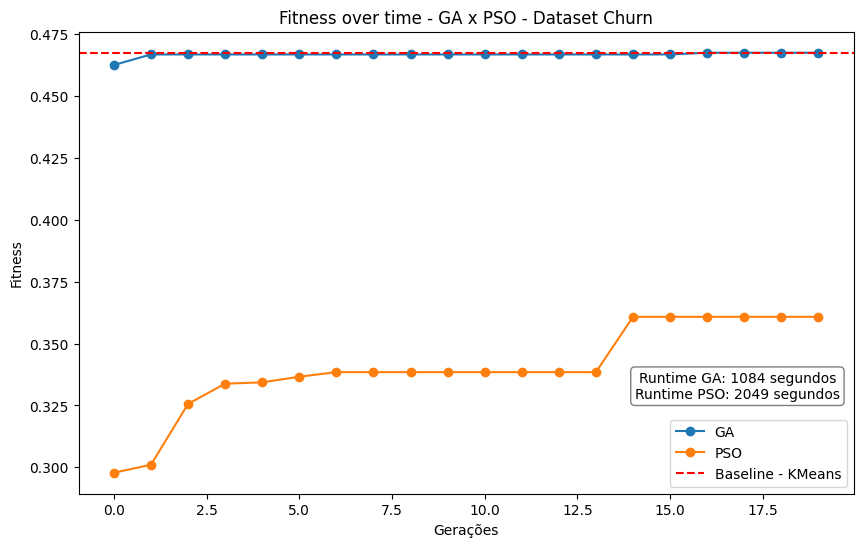

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting Results

ax.plot(results['GA_fitness_over_time'], label='GA', marker='o')
ax.plot(results['PSO_fitness_over_time'], label='PSO', marker='o') 
ax.axhline(y=silhouette, color='r', linestyle='--', label='Baseline - KMeans')
ax.legend()
ax.set_xlabel('Gerações')
ax.set_ylabel('Fitness')
ax.set_title('Fitness over time - GA x PSO - Dataset Churn')

# Plot Runtime results
text_box_runtime_GA = f"Runtime GA: {results['GA_runtime']:.0f} segundos"
text_box_runtime_PSO = f"Runtime PSO: {results['PSO_runtime']:.0f} segundos"
text_box_content = text_box_runtime_GA + '\n' + text_box_runtime_PSO

ax.text(0.85, 0.2, text_box_content, transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

## Dataset 2: Housing Prices  
Com este dataset, será feita uma regressão com o modelo SVR usando features selecionadas por computação evolucionária. A ideia será comparar essa solução com o modelo utilizando todas as features, e com o modelo utilizando features escolhidas pelo PCA. As métricas utilizadas foram R² e MSE.

In [3]:
df_housing = pd.read_csv('./data/housing_price.csv')
print(df_housing.head(1))
print(df_housing.info())
print(df_housing.head(1))

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int

In [4]:
dict_house_bool = {'no':0, 'yes':1}
booleans_house = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for boolean_col in booleans_house:
    df_housing[boolean_col] = df_housing[boolean_col].map(dict_house_bool)

dict_house_furnish = {False:0, True:1}
dummies_furnish = pd.get_dummies(df_housing.furnishingstatus)
for furnish_col in dummies_furnish:
    dummies_furnish[furnish_col] = dummies_furnish[furnish_col].map(dict_house_furnish)

df_housing = df_housing.drop('furnishingstatus',axis=1)
dummies_furnish = dummies_furnish.drop('unfurnished',axis=1)
for col in dummies_furnish:
    df_housing[col] = dummies_furnish[col]

df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


### Computação evolucionária

In [5]:
# Função para decodificar o indivíduo
def decode_ind(ind, beta):
    """
    Decodificar um indivíduo definindo 'beta' elementos com a maior
    probabilidade como 1 e os demais como 0.

    Parâmetros:
    ind: indivíduo a ser decodificado.
    beta: O número de elementos a serem definidos como 1.

    Retorna:
    ind: indivíduo a ser decodificado.
    """

    # Obtenha os índices dos 'beta' maiores elementos
    indices_of_highest = sorted(range(len(ind)), key=lambda i: ind[i], reverse=True)[:beta]
    # []

    # Innicialize o indivíduo decodificado
    decoded_ind = [0] * len(ind)

    # Inclua um total de 'beta' elementos iguais a 1
    for index in indices_of_highest:
        decoded_ind[index] = 1

    return decoded_ind

In [6]:
# Função para calcular a fitness no GA e no PSO
# Função para calcular a fitness
def fitness_function(ind_encoded, beta, X, y):

    # ind é um subconjunto de features: [0 0 1 0 0 1 ...]
    ind = decode_ind(ind_encoded, beta)
    m, n = X.shape

    cols = [i for i in range(n) if ind[i] == 1] # índices das features selecionadas
    X_subset = X[:, cols] # selecionar somente as features selecionadas
    svr = SVR()
    score = -1.0* np.mean(cross_val_score(svr, X_subset, y, cv=10, scoring='neg_mean_squared_error'))

    return score

#### Generative Algorithm (GA)

In [7]:
# função que gera pop inicial
def init_pop(P,X):
    """
    Inicialize um conjunto de indivíduos, cada um contendo elementos entre 0 e 1.

    Parâmetros:
    X: dados de treinamento
    P: número de indivíduos na população

    Retorna:
    pop: população inicial
    """
    pop = []
    m, n = X.shape
    for _ in range(P):
        ind = [np.random.uniform(0, 1) for __ in range(n)] # chaves aleatórias
        pop.append(ind)

    return pop

In [8]:
def select_individuals(population, elite_size): # elitism is used
    """
    Selecionar dois indivíduos aleatoriamente da população P vezes.
    Como utilizamos elitismo, devemos reduzir o número de indivídos selecionados

    Parâmetros:
    population: Lista ou array representando a população.
    elite_size: Tamanho da elite

    Retorna:
    Lista de tuplas, cada uma contendo os índices de dois indivíduos selecionados aleatoriamente.
    """
    population_size = len(population)-math.ceil(elite_size)

    selections = []
    for _ in range(population_size):
        # Selecione dois indivíduos aleatoriamente com reposição
        selected_indices = np.random.choice(population_size, size=2, replace=True)
        selections.append(tuple(selected_indices))

    return selections

In [9]:
def uniform_crossover(parent1, parent2, crossover_rate=0.5):
    """
    Realizar crossover uniforme entre dois pais.

    Parâmetros:

    parent1: genes do primeiro pai.
    parent2: genes do segundo pai.
    crossover_rate: Probabilidade de selecionar um gene do primeiro pai.

    Retorna:
    genes do filho após o crossover uniforme.
    """

    # Gerar uma lista aleatória booleana, onde o elemento da lista é igual a True, se p < crossover_rate
    mask = np.random.rand(len(parent1)) < crossover_rate

    # Realizar crossover
    child = np.where(mask, parent1, parent2)

    return child.tolist()

In [10]:
def mutation(child, p_m=0.2, mutation_std_dev=0.01):
    """

    Aplicar mutação aos genes de uma criança.

    Parâmetros:
    child: genes da criança.
    p_m: Probabilidade de aplicar mutação a cada gene.
    mutation_std_dev: Desvio padrão da distribuição normal para a mutação.

    Retorna:
    genes da criança após a mutação.

    * obs.: o std_dev foi reduzido e 0.1 para 0.01
    """
    mutated_child = np.copy(child)

    # Faça o loop em cada gene e mute-o com probabilidade p_m
    for i in range(len(child)):
        if np.random.rand() < p_m:
            # Aplique a mutação perturbando o gene com uma distribuição normal
            mutated_child[i] += np.random.normal(loc=0, scale=mutation_std_dev)

    return mutated_child.tolist()

In [11]:
def genetic_algorithm(pop_size, p_crossover, p_mutation, data, labels, beta, max_generations, elite_size):
    """
    Loop do GA.

    Parâmetros:
    - pop_size: Population size.
    - p_crossover: Crossover probability.
    - p_mutation: Mutation probability.
    - data: Dataset.
    - labels: labels das amostras.
    - beta: tamanho do subconjunto de features
    - max_generations: Maximum number of generations.
    - elite_size: tamanho da elite

    Retorna:
    - Melhor subconjunto de características obtido pelo GA
    """
    # inicializar os dados
    X = data
    y = labels
    # gerar pop inicial
    pop = init_pop(pop_size,X)
    # Listas para guardar melhores fitness e indivíduos
    fitness_over_time = []
    bestind_over_time = []
    for generation in range(max_generations):
        print("G: " + str(generation))
        # Avaliar a fitness de cada indivíduo
        #fitness_values = [fitness_function(ind, beta, X, y) for ind in pop]
        # Encontrar melhores indivíduos de acordo com a fitness
        best_ind = sorted(pop, key=lambda ind: fitness_function(ind, beta, X, y))[:math.ceil(elite_size)]
        # Guardar as melhores fitness e indivíduos
        best_fitness_val = fitness_function(best_ind[0], beta, X, y)
        print(best_fitness_val)
        fitness_over_time.append(best_fitness_val)
        bestind_over_time.append(best_ind[0])
        #print(best_ind[0])

        # Selecionar pais para reprodução
        selections = select_individuals(pop, elite_size)

        # Gerar nova pop através de crossover e mutação
        offspring = []
        for parent1, parent2 in selections:
            child = uniform_crossover(pop[parent1], pop[parent2], p_crossover)
            child = mutation(child, p_mutation)
            offspring.append(child)

        # Atualizar população
        pop = offspring
        pop.extend(best_ind)

    return best_ind[0], fitness_over_time, bestind_over_time

#### Particle Swarm Optimization (PSO)

In [12]:
# função que gera enxame inicial
def init_swarm(P,X):
    """
    Inicialize um enxame com P partículas, cada uma contendo elementos entre 0 e 1.

    Parâmetros:
    X: dados de treinamento
    P: número de indivíduos no enxame

    Retorna:
    pos = posição inicial das P partículas do enxame
    vel = velocidade inicial das P partículas do enxame
    pos_best = vetor de melhores posições conhecidas pela partícula
    """
    pos = []
    vel = []
    pos_best = []
    m, n = X.shape
    for _ in range(P):
        pos_ind = [np.random.uniform(0, 1) for __ in range(n)] # chaves aleatórias
        pos.append(pos_ind)
        pos_best.append(pos_ind)
        vel.append(np.random.uniform(-1,1, size = n))

    return pos, vel, pos_best

In [13]:
# atualizar velocidade da partícula
def update_velocity(pos, vel, pos_best, global_best, w, c1, c2):
  '''
    Atualiza a velocidade da partícula usando a fórmula da Otimização por Enxame de Partículas (PSO).

    Parâmetros:
    pos: posição atual da partícula
    vel: velocidade atual da partícula
    pos_best: Melhor posição global entre todas as partículas.
    c1: Parâmetro cognitivo.
    c2: Parâmetro social.
    w: Peso de inércia.

    Retorna:
    - Velocidade atualizada para a partícula.
  '''
  # inicializar vel atualizada
  vel_updated = []
  # loop em cada posição i da partícula
  for i in range(len(pos)):
      # Gera números aleatórios no intervalo [0, 1]
      r1 = np.random.uniform(0,1)
      r2 = np.random.uniform(0,1)

      # Calcula os componentes cognitivo e social da atualização de velocidade
      vel_cognitive = c1 * r1 * (pos_best[i] - pos[i])
      vel_social = c2 * r2 * (global_best[i] - pos[i])

      # Atualiza a velocidade i usando a fórmula do PSO
      vel_updated.append(w * vel[i] + vel_cognitive + vel_social)

  # Retorna a velocidade atualizada para a partícula
  return np.array(vel_updated)

In [14]:
# definir função de atualização da posição
def update_position(pos, vel, bounds):
  '''
    Atualiza a posição da partícula a partir da nova velocidade.

    Parâmetros:
    pos: posição atual da partícula
    vel: velocidade atualizada da partícula
    bounds: limites do ambiente

    Retorna:
    - Velocidade atualizada para a partícula.
  '''
  pos_updated = []
  for i in range(len(pos)):
      pos_updated.append(np.clip(pos[i]+vel[i], a_min=bounds[0], a_max=bounds[1]))
  return pos_updated

In [15]:
def pso(swarm_size, c1, c2, w, data, labels, beta, max_iters):
  """
  Loop do PSO.

  Parâmetros:
  swarm_size: num de partículas.
  c1: Parâmetro cognitivo.
  c2: Parâmetro social.
  w: Peso de inércia.
  data: Dataset.
  labels: labels das amostras.
  beta: tamanho do subconjunto de features
  max_iters: Número máximo de períodos.

  Retorna:
  Melhor subconjunto de features obtido pelo pso
  """
  # inicializar os dados
  X = data
  y = labels
  bounds = [0, 1] # já que posições são chaves aleatórias
  # inicializar o enxame
  pos_swarm, vel_swarm, pos_best_swarm = init_swarm(swarm_size,X)
  # lista para armazenar evolução da fitness
  fitness_over_time = []
  bestind_over_time = []

  # comece o loop
  best_ind = pos_swarm[0] # initialize global best
  for iter in range(max_iters):
      print("iter: " + str(iter))
      # avaliar fitness das partículas do enxame
      global_best_fitness = fitness_function(best_ind, beta, X, y) # fitness da melhor posição global
      for j,ind in enumerate(pos_swarm):
        score = fitness_function(ind, beta, X, y) # fitness da posição atual
        score_known_best = fitness_function(pos_best_swarm[j], beta, X, y) # fitness da melhor posição conhecida
        if score < score_known_best:
          pos_best_swarm[j] = ind # se uma posição melhor for encontrada
        if score < global_best_fitness:
          best_ind = ind

      # armazenar melhor fitness deste período
      best_fitness_val = fitness_function(best_ind, beta, X, y)
      print(best_fitness_val)
      fitness_over_time.append(best_fitness_val)
      bestind_over_time.append(best_ind)

      # cycle through swarm and update velocities and position
      for j in range(swarm_size):
          vel_swarm[j] = update_velocity(pos_swarm[j], vel_swarm[j], pos_best_swarm[j], best_ind, w, c1, c2)
          #pos_swarm[j] = update_position(pos_swarm[j], vel_swarm[j], [-1000,1000])
          pos_swarm[j] = update_position(pos_swarm[j], vel_swarm[j], bounds)

  return best_ind, fitness_over_time, bestind_over_time

### Aplicação no modelo

In [16]:
# Dividindo o conjunto de dados em X e y
X_house = df_housing.drop('price',axis=1).copy()
y_house = df_housing.price.copy()

# Normalizando os valores do dataset
scaler_house = MinMaxScaler()
X_house = scaler_house.fit_transform(X_house)

# Dividindo X e y em treino e teste
X_train_house, X_test_house, y_train_house, y_test_house = train_test_split(X_house, y_house, test_size=0.25, random_state=101)

print(X_train_house[:3])
print(X_test_house[:3])
print(y_train_house[:3])
print(y_test_house[:3])

[[0.05154639 0.4        0.         0.33333333 1.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.12852234 0.4        0.         0.         1.         0.
  0.         0.         0.         0.66666667 1.         0.
  0.        ]
 [0.33333333 0.4        0.33333333 0.66666667 1.         0.
  0.         0.         1.         0.         0.         0.
  0.        ]]
[[0.32920962 0.2        0.         0.         1.         0.
  0.         0.         1.         1.         0.         0.
  1.        ]
 [0.20274914 0.4        0.33333333 0.33333333 1.         1.
  0.         0.         1.         0.66666667 0.         1.
  0.        ]
 [0.18213058 0.4        0.33333333 0.33333333 1.         0.
  1.         0.         0.         0.33333333 0.         0.
  0.        ]]
533    2100000
379    3633000
127    5880000
Name: price, dtype: int64
225    4753000
18     8890000
48     7455000
Name: price, dtype: int64


In [17]:
# Gridsearch dos melhores parâmetros do SVR
best_params = []
best_mse = np.inf
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for degree in [1, 3, 5, 10]:
        for gamma in ['scale', 'auto']:
            for C in [0.5, 1, 1.5]:
                print(f'Parâmetros: Kernel={kernel}, Degree={degree}, Gamma={gamma}, C={C}')
                for i in range(10):
                    svr_grid = SVR(kernel=kernel,degree=degree,gamma=gamma,C=C)
                    svr_grid.fit(X_train_house, y_train_house)
                    pred_grid = svr_grid.predict(X_test_house)
                    mse_grid = mean_squared_error(y_test_house, pred_grid)
                    if mse_grid < best_mse:
                        best_params = []
                        best_mse = mse_grid
                        best_params.append(kernel)
                        best_params.append(degree)
                        best_params.append(gamma)
                        best_params.append(C)
                        print('Otimização encontrada!')
print(f'\nMelhores parâmetros encontrados: Kernel={best_params[0]}, Degree={best_params[1]}, Gamma={best_params[2]}, C={best_params[3]}')
print(f'MSE encontrado: {best_mse}')

Parâmetros: Kernel=linear, Degree=1, Gamma=scale, C=0.5
Otimização encontrada!
Parâmetros: Kernel=linear, Degree=1, Gamma=scale, C=1
Otimização encontrada!
Parâmetros: Kernel=linear, Degree=1, Gamma=scale, C=1.5
Otimização encontrada!
Parâmetros: Kernel=linear, Degree=1, Gamma=auto, C=0.5
Parâmetros: Kernel=linear, Degree=1, Gamma=auto, C=1
Parâmetros: Kernel=linear, Degree=1, Gamma=auto, C=1.5
Parâmetros: Kernel=linear, Degree=3, Gamma=scale, C=0.5
Parâmetros: Kernel=linear, Degree=3, Gamma=scale, C=1
Parâmetros: Kernel=linear, Degree=3, Gamma=scale, C=1.5
Parâmetros: Kernel=linear, Degree=3, Gamma=auto, C=0.5
Parâmetros: Kernel=linear, Degree=3, Gamma=auto, C=1
Parâmetros: Kernel=linear, Degree=3, Gamma=auto, C=1.5
Parâmetros: Kernel=linear, Degree=5, Gamma=scale, C=0.5
Parâmetros: Kernel=linear, Degree=5, Gamma=scale, C=1
Parâmetros: Kernel=linear, Degree=5, Gamma=scale, C=1.5
Parâmetros: Kernel=linear, Degree=5, Gamma=auto, C=0.5
Parâmetros: Kernel=linear, Degree=5, Gamma=auto, C=1

In [18]:
# Gridsearch dos melhores parâmetros do SVR
best_params = []
best_mse = np.inf
for criterion in ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']:
    for max_features in ['sqrt', 'log2', None]:
        print(f'Parâmetros: Critério={criterion}, Features máximas={max_features}')
        for i in range(10):
            dtr_grid = DecisionTreeRegressor(criterion=criterion, max_features=max_features, random_state=101)
            dtr_grid.fit(X_train_house, y_train_house)
            pred_grid = dtr_grid.predict(X_test_house)
            mse_grid = mean_squared_error(y_test_house, pred_grid)
            if mse_grid < best_mse:
                best_params = []
                best_mse = mse_grid
                best_params.append(criterion)
                best_params.append(max_features)
                print('Otimização encontrada!')
print(f'\nMelhores parâmetros encontrados: Critério={best_params[0]}, Features máximas={best_params[1]}')
print(f'MSE encontrado: {best_mse}')

Parâmetros: Critério=squared_error, Features máximas=sqrt
Otimização encontrada!
Parâmetros: Critério=squared_error, Features máximas=log2
Parâmetros: Critério=squared_error, Features máximas=None
Otimização encontrada!
Parâmetros: Critério=friedman_mse, Features máximas=sqrt
Parâmetros: Critério=friedman_mse, Features máximas=log2
Parâmetros: Critério=friedman_mse, Features máximas=None
Parâmetros: Critério=absolute_error, Features máximas=sqrt
Parâmetros: Critério=absolute_error, Features máximas=log2
Parâmetros: Critério=absolute_error, Features máximas=None
Parâmetros: Critério=poisson, Features máximas=sqrt
Otimização encontrada!
Parâmetros: Critério=poisson, Features máximas=log2
Parâmetros: Critério=poisson, Features máximas=None

Melhores parâmetros encontrados: Critério=poisson, Features máximas=sqrt
MSE encontrado: 2239371193959.854


#### GA

In [21]:
# Selecionar um subconjunto de características de X_house com o GA
best_fit_house_ga = np.inf
beta_house = int(round(X_train_house.shape[1]*0.33))

ind_house_ga, fitness_over_time_house_ga, bestind_over_time_house_ga = genetic_algorithm(pop_size=300, elite_size=50, 
                                                                                         p_crossover=0.5, p_mutation=0.2, 
                                                                                         data=X_train_house,
                                                                                         labels=y_train_house,
                                                                                         beta=beta_house, max_generations=10)
best_fit_house_ga = fitness_function(ind_house_ga, beta_house, X_train_house, y_train_house)
selected_cols_house_ga = [index for index, value in enumerate(decode_ind(ind_house_ga, beta_house)) if value == 1]

print('Melhor fitness:', best_fit_house_ga)
print('Colunas selecionadas:', selected_cols_house_ga)

G: 0
3796058764570.2983
G: 1
3796058764570.2983
G: 2
3796058764570.2983
G: 3
3796058764570.2983
G: 4
3796058764570.2983
G: 5
3796058764570.2983
G: 6
3796058764570.2983
G: 7
3796058764570.2983
G: 8
3796058764570.2983
G: 9
3796058764570.2983
Melhor fitness: 3796058764570.2983
Colunas selecionadas: [0, 2, 7, 8]


#### PSO

In [22]:
# Selecionar um subconjunto de características de X com o PSO
best_fit_house_pso = np.inf

ind_house_pso, fitness_over_time_house_pso, bestind_over_time_house_pso = pso(swarm_size=300, c1=2, c2=2, w=0.5, 
                                                                              data=X_house, labels=y_house,
                                                                              beta=beta_house, max_iters=10)
best_fit_house_pso = fitness_function(ind_house_pso, beta_house, X_train_house, y_train_house)
selected_cols_house_pso = [index for index, value in enumerate(decode_ind(ind_house_pso, beta_house)) if value == 1]

print('Melhor fitness:', best_fit_house_pso)
print('Colunas selecionadas:', selected_cols_house_pso)

iter: 0
4144703872161.622
iter: 1
4144701572041.025
iter: 2
4144700975017.5
iter: 3
4144693756288.3623
iter: 4
4144673116336.8857
iter: 5
4144667454237.249
iter: 6
4144666245587.0874
iter: 7
4144621597484.8604
iter: 8
4144612622619.1655
iter: 9
4144574733932.5796
Melhor fitness: 3796108262733.5337
Colunas selecionadas: [0, 3, 7, 10]


#### PCA

In [23]:
pca_house = PCA(n_components=beta_house)
X_train_house_PCA = pca_house.fit_transform(X_train_house)
X_test_house_PCA = pca_house.fit_transform(X_test_house)

#### Comparação dos métodos

In [24]:
# Subconjunto de características
X_train_house_ga = X_train_house[:, selected_cols_house_ga]
X_test_house_ga = X_test_house[:, selected_cols_house_ga]
X_train_house_pso = X_train_house[:, selected_cols_house_pso]
X_test_house_pso = X_test_house[:, selected_cols_house_pso]

# Todas as características
# Não é necessário modificar X_train ou X_test, pois eles já contêm todas as características

# Inicializar e treinar regressores
svr_house_pca = SVR()
svr_house_pca.fit(X_train_house_PCA, y_train_house)
svr_house_ga = SVR()
svr_house_ga.fit(X_train_house_ga, y_train_house)
svr_house_pso = SVR()
svr_house_pso.fit(X_train_house_pso, y_train_house)
svr_house = SVR()
svr_house.fit(X_train_house, y_train_house)

# Avaliar e comparar o desempenho dos classificadores

# Realizar previsões
y_pred_house_pca = svr_house_pca.predict(X_test_house_PCA)
y_pred_house_ga = svr_house_ga.predict(X_test_house_ga)
y_pred_house_pso = svr_house_pso.predict(X_test_house_pso)
y_pred_house = svr_house.predict(X_test_house)

# Avaliar o R² score
r2_house_pca = r2_score(y_test_house, y_pred_house_pca)
r2_house_ga = r2_score(y_test_house, y_pred_house_ga)
r2_house_pso = r2_score(y_test_house, y_pred_house_pso)
r2_house = r2_score(y_test_house, y_pred_house)

# Imprimir resultados
print(f"R² com subconjunto por PCA: {r2_house_pca:.2f}")
print(f"R² com subconjunto por GA: {r2_house_ga:.2f}")
print(f"R² com subconjunto por PSO: {r2_house_pso:.2f}")
print(f"R² com todas as características: {r2_house:.2f}")

R² com subconjunto por PCA: -0.12
R² com subconjunto por GA: -0.12
R² com subconjunto por PSO: -0.12
R² com todas as características: -0.12


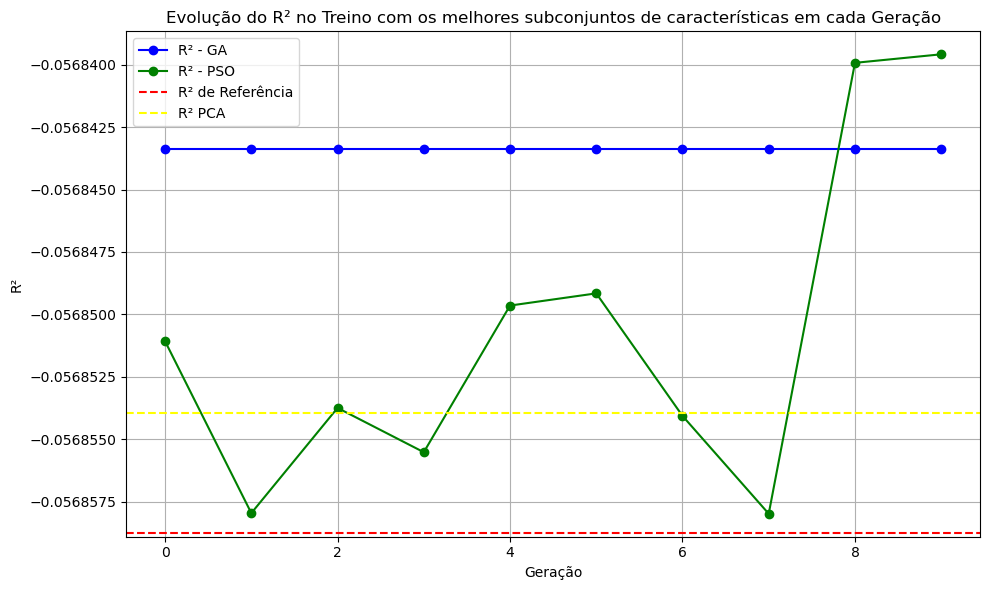

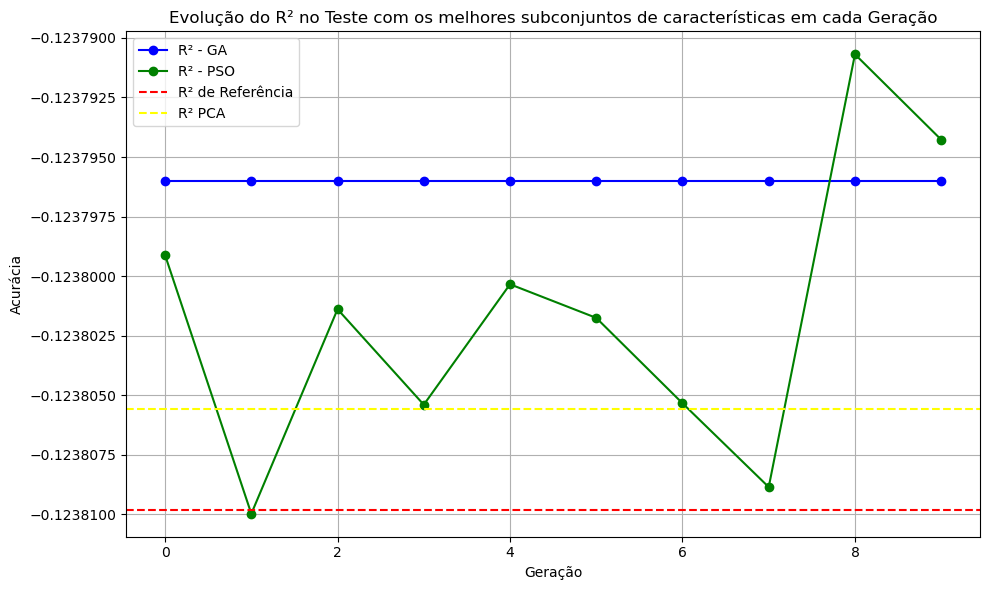

In [25]:
# Supondo que X seja seu conjunto de dados, subsets seja uma lista de selected_cols e y seja sua variável alvo

# Avaliar o desempenho de referência
baseline_r2_train_house = r2_score(y_train_house, svr_house.predict(X_train_house))
baseline_r2_test_house = r2_score(y_test_house, svr_house.predict(X_test_house))

# Avaliar o desempenho do PCA
pca_r2_train_house = r2_score(y_train_house, svr_house_pca.predict(X_train_house_PCA))
pca_r2_test_house = r2_score(y_test_house, svr_house_pca.predict(X_test_house_PCA))


# Armazenar os resultados do GA
train_r2_house_ga = []
test_r2_house_ga = []

# Iterar sobre subconjuntos de características do GA
for ind in bestind_over_time_house_ga:
    subset = [index for index, value in enumerate(decode_ind(ind, beta_house)) if value == 1]
    # Extrair o subconjunto de características
    X_subset_train_house_ga = X_train_house[:, subset]
    X_subset_test_house_ga = X_test_house[:, subset]

    # Inicializar e treinar o classificador
    svr_subset_house_ga = SVR()
    svr_subset_house_ga.fit(X_subset_train_house_ga, y_train_house)

    # Avaliar o desempenho
    r2_train_house_ga = r2_score(y_train_house, svr_subset_house_ga.predict(X_subset_train_house_ga))
    r2_test_house_ga = r2_score(y_test_house, svr_subset_house_ga.predict(X_subset_test_house_ga))

    # Armazenar os resultados
    train_r2_house_ga.append(r2_train_house_ga)
    test_r2_house_ga.append(r2_test_house_ga)


# Armazenar os resultados do PSO
train_r2_house_pso = []
test_r2_house_pso = []

# Iterar sobre subconjuntos de características do PSO
for ind in bestind_over_time_house_pso:
    subset = [index for index, value in enumerate(decode_ind(ind, beta_house)) if value == 1]
    # Extrair o subconjunto de características
    X_subset_train_house_pso = X_train_house[:, subset]
    X_subset_test_house_pso = X_test_house[:, subset]

    # Inicializar e treinar o classificador
    svr_subset_house_pso = SVR()
    svr_subset_house_pso.fit(X_subset_train_house_pso, y_train_house)

    # Avaliar o desempenho
    r2_train_house_pso = r2_score(y_train_house, svr_subset_house_pso.predict(X_subset_train_house_pso))
    r2_test_house_pso = r2_score(y_test_house, svr_subset_house_pso.predict(X_subset_test_house_pso))

    # Armazenar os resultados
    train_r2_house_pso.append(r2_train_house_pso)
    test_r2_house_pso.append(r2_test_house_pso)


# Gráfico do treino
plt.figure(figsize=(10, 6))
plt.plot(train_r2_house_ga, marker='o', color='blue', label='R² - GA')
plt.plot(train_r2_house_pso, marker='o', color='green', label='R² - PSO')
# Desenhe uma linha constante para o baseline (classificador que usa todas as características)
plt.axhline(y=baseline_r2_train_house, color='red', linestyle='--', label='R² de Referência')
plt.axhline(y=pca_r2_train_house, color='yellow', linestyle='--', label='R² PCA')
plt.xlabel('Geração')
plt.ylabel('R²')
plt.title('Evolução do R² no Treino com os melhores subconjuntos de características em cada Geração')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico do teste
plt.figure(figsize=(10, 6))
plt.plot(test_r2_house_ga, marker='o', color='blue', label='R² - GA')
plt.plot(test_r2_house_pso, marker='o', color='green', label='R² - PSO')
# Desenhe uma linha constante para o baseline (classificador que usa todas as características)
plt.axhline(y=baseline_r2_test_house, color='r', linestyle='--', label='R² de Referência')
plt.axhline(y=pca_r2_test_house, color='yellow', linestyle='--', label='R² PCA')
plt.xlabel('Geração')
plt.ylabel('Acurácia')
plt.title('Evolução do R² no Teste com os melhores subconjuntos de características em cada Geração')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Discussão dos resultados  
O PSO convergiu acima do GA no treino e no teste, e ambos ficaram acima dos modelos com seleção de categorias por PCA e sem seleção nenhuma de categorias. No entanto, nem o SVR nem o DecisionTreeRegressor se mostraram modelos robustos para essa base de dados, resultando em um valor de R² inferior a 0 em todas as abordagens. Porém, a superioridade das abordagens evolucionárias é bastante notável.